# Computational Project I:
# Association Rules and Prediction Rules for Financial Data Miningc

## Import packages

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from matplotlib import pyplot as plt
from functools import partial
from itertools import product
from IPython.display import display,Markdown

import warnings

warnings.filterwarnings('ignore')

## Download data

Download the time series of `MSFT` and `GOOGL`’s daily closing price started from `2005-01-01` to now from Yahoo Finance with `yfinance` package.

In [2]:
stock_names = ["MSFT","GOOGL"]
duration = {'start':'2005-01-01','end':'2023-03-01'}
datas = map(partial(yf.download,**duration,threads=False),stock_names)
S = pd.DataFrame({name:data['Adj Close'] for name,data in zip(stock_names,datas)})
S

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,MSFT,GOOGL
Date,,
2005-01-03,18.813694,5.072823
2005-01-04,18.884052,4.867367
2005-01-05,18.841846,4.842593
2005-01-06,18.820734,4.718468
2005-01-07,18.764446,4.851101
...,...,...
2023-02-22,251.509995,91.650002
2023-02-23,254.770004,90.889999
2023-02-24,249.220001,89.129997


## Data Preprocessing

Let time start at $t=0$. Denote the stock’s time series by 𝑆(𝑡), then compute its daily return rate 𝑋(𝑡) with

$$
X(t) = ln [\frac{S(t)}{S(t-1)}]
$$

and denote the length of 𝑋(𝑡) by 𝑁 .

In [3]:
X = np.log(S).diff()
X

,MSFT,GOOGL
Date,,
2005-01-03,NaN,NaN
2005-01-04,0.003733,-0.041344
2005-01-05,-0.002237,-0.005103
2005-01-06,-0.001121,-0.025966
2005-01-07,-0.002995,0.027721
...,...,...
2023-02-22,-0.004602,-0.001526
2023-02-23,0.012878,-0.008327
2023-02-24,-0.022025,-0.019554


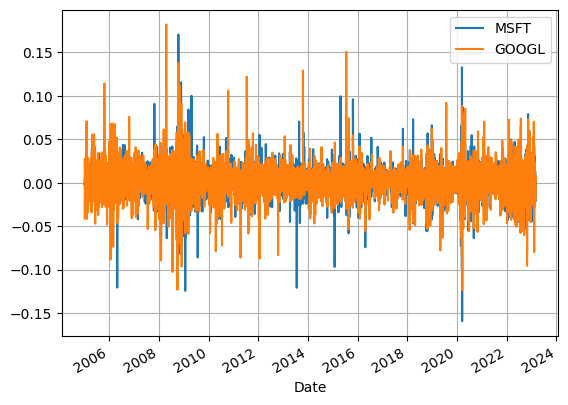

In [4]:
X.plot()
plt.grid(True)
plt.savefig("../img/log_return.pdf")
plt.show()

## 2 Exponential moving average
Define the stock’s 𝑤-day exponential moving average (EMA) at time 𝑡 as
$$
𝑀 (𝑡, 𝑤) = 𝑎𝑆(𝑡) + (1 − 𝑎)𝑀 (𝑡 − 1, 𝑤)
$$
for some smoothing constant 𝑎. The base case is $𝑀 (0, 𝑤) ≡ 𝑆(0)$.

- Consider 𝑎 = 1/𝑤. Plot 𝑀 (𝑡, 𝑤) for 𝑤 = 30, 100, and 300. The three win-
dows roughly correspond to one month, one season, and one year.

In [5]:
def EMA(S:pd.DataFrame,omega=30,afn=lambda w:1/w):
    a = afn(omega)
    M = S.copy()
    M.iloc[0] = S.iloc[0]
    for t in range(1,len(S)):
        M.iloc[t] = a*S.iloc[t] + (1-a)*M.iloc[t-1]
    return M

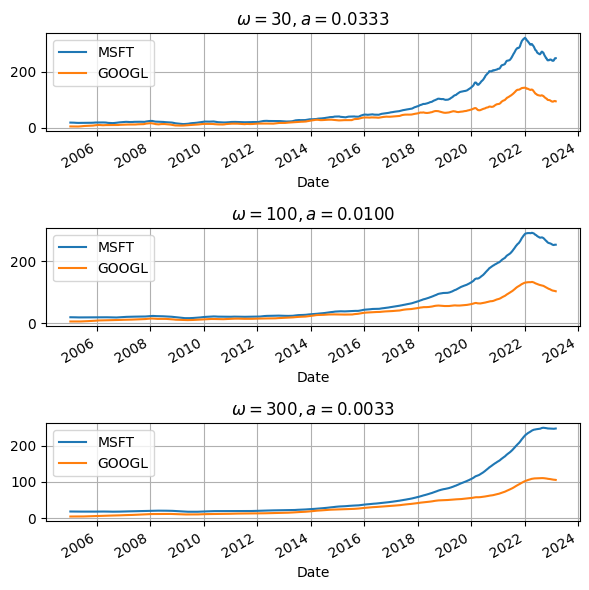

In [6]:
afn = lambda w:1/w
Ms = {w:EMA(S,w,afn=afn) for w in (30,100,300)}
num = len(Ms)
fig, axes = plt.subplots(3,1,figsize=(6,6))
for ax,(w,M) in zip(axes,Ms.items()):
    M.plot(ax=ax)
    ax.set_title(rf"$\omega={w},a={afn(w):.4f}$")
    ax.grid(True)
fig.tight_layout()
plt.savefig("../img/ema1.pdf")
plt.show()

- Repeat last step using 𝑎 = 2/(𝑤 + 1), which is the prevalent definition in
finance

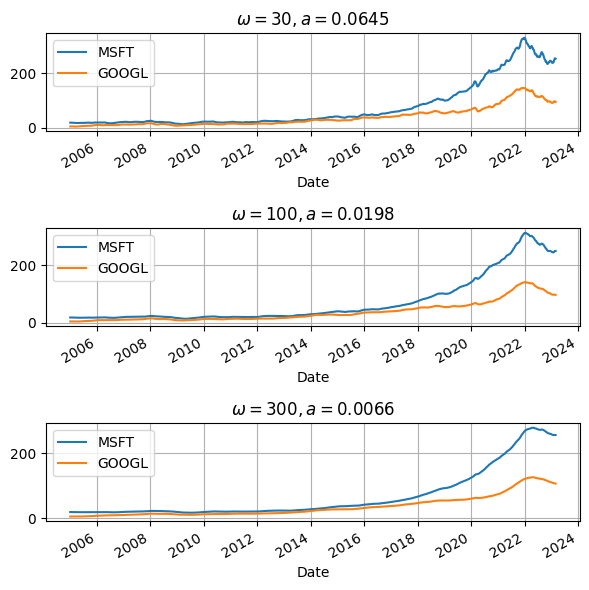

In [7]:
afn = lambda w:2/(w+1)
Ms = {w:EMA(S,w,afn=afn) for w in (30,100,300)}
num = len(Ms)
fig, axes = plt.subplots(3,1,figsize=(6,6))
for ax,(w,M) in zip(axes,Ms.items()):
    M.plot(ax=ax)
    ax.set_title(rf"$\omega={w},a={afn(w):.4f}$")
    ax.grid(True)
fig.tight_layout()
plt.savefig("../img/ema2.pdf")
plt.show()

# 3 Cumulative Distribution Function
Let us regard the values of 𝑋(𝑡) as realizations of a random variable 𝑋.
Plot its CDF $F_X (x)$.

In [8]:
def ecdf(Xs:pd.Series,x):
    return (Xs <= x).mean()

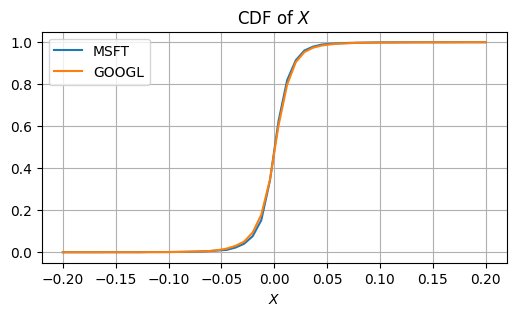

In [9]:
fig,ax = plt.subplots(figsize=(6,3))
x_range = np.linspace(-0.2,0.2,50)
for stock in X.columns:
    ecdfval = list(map(partial(ecdf,X[stock]),x_range))
    ax.plot(x_range,ecdfval,label=stock)
ax.set_title("CDF of $X$")
ax.set_xlabel("$X$")
ax.legend()
ax.grid(True)
plt.savefig("../img/ecdf.pdf")
plt.show()

### 3.1 Logistic Function
We may fit $F_X (x)$ with a logistic function
$$
L(x) = \frac1{1 + \exp[−b(x-x^*)]} .
$$ 
In physics, this is also called a Fermi-Dirac distribution.
- What is $L(x^*)$ and hence your empirical $x^*$?
    $$
    L(x^*) = \frac12 .
    $$

    Thus, $x^*=L^{-1}(\frac12)=F_X^{-1}(\frac12)=quantile(X,\frac12)$.
- What is $L^{'}(x^*)$ and hence your empirical $b$?.
    $$
    L^{'}(x) = \frac{b\exp[−b(x-x^*)]}{(1+\exp[−b(x-x^*)])^2} .
    $$
    $$
    L^{'}(x^*) = \frac{b}{4} .
    $$

    Thus, $b=4L^{'}(x^*)=4F_X^{'}(x^*)\approx 4\frac{F_X(x^*+\delta x)-F_X(x^*-\delta x)}{2\delta x}$.

- Plot your empirical $L(x)$ atop $F_X(x)$.

In [10]:
def logistic(x,x_star=0,b=1):
    return 1/(1+np.exp(-b*(x-x_star)))

def logistic_derivate(x,x_star=0,b=1):
    e = np.exp(-b*(x-x_star))
    return b*e/(1+e)**2

def logistic_fit(Xs:pd.Series,dx=0.01):
    x_star = Xs.quantile(1/2)
    FX_u = ecdf(Xs,x_star+dx)
    FX_d = ecdf(Xs,x_star-dx)
    b = (FX_u-FX_d)*2/dx
    return x_star,b

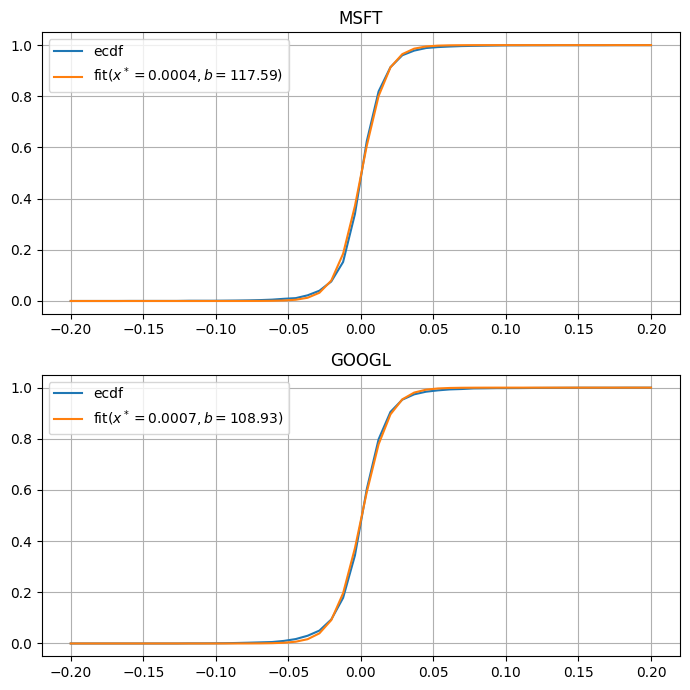

In [11]:
x_range = np.linspace(-0.2,0.2,50)
m = len(X.columns)
fig, axes = plt.subplots(2,1,figsize=(7,7))
for stock,ax in zip(X.columns,axes):
    ax.set_title(f"{stock}")
    ecdfval = list(map(partial(ecdf,X[stock]),x_range))
    ax.plot(x_range,ecdfval,label="ecdf")
    x_star,b = logistic_fit(X[stock],dx=0.01)
    fitval = logistic(x_range,x_star=x_star,b=b)
    ax.plot(x_range,fitval,label=rf"fit($x^*={x_star:.4f},b={b:.2f}$)")
    ax.legend()
    ax.grid(True)
fig.tight_layout()
plt.savefig("../img/logistic_fit.pdf")
plt.show()

### 3.2 Kolmogorov-Smirnov Test
We can f if our fitting is good with the Kolmogorov-Smirnov f. Our null
hypothesis is that $L(x)$ fits $F_X (x)$ well. Define $D = \max_x֓|F_X(x) - L(x)|$. 
If $\sqrt{N} D > \eta_{\alpha}$ , we reject the null hypothesis at a significance level $\alpha$. The
threshold $\eta_{\alpha}$ solves
$$
\frac{\sqrt{2\eta_{\alpha}}}{\eta_{\alpha}}\sum_{k=1}^{\infty}\exp\left[-\frac{(2k-1)^2\pi^2}{8\eta_{\alpha}^2}\right]=1-\alpha
$$
- Does the f reject the null hypothesis at 𝛼 = 0.05? At this significance
level, the null hypothesis is wrongly rejected once every 20 times.

In [12]:
from scipy.special import kolmogi

def ks_f(FX:np.ndarray,L:np.ndarray,alpha=0.05):
    N = len(FX)
    D = (FX-L).max()
    eta = kolmogi(1-alpha)
    stats = N**.5*D
    result = stats > eta
    return result,stats,eta

In [13]:
x_range = np.linspace(-0.2,0.2,50)
alpha = 0.05
for stock in X.columns:
    FX = list(map(partial(ecdf,X[stock]),x_range))
    x_star,b = logistic_fit(X[stock],dx=0.01)
    L = logistic(x_range,x_star=x_star,b=b)
    result, stats, eta = ks_f(FX,L,alpha=alpha)
    display(Markdown(rf"({stock}) KS-Test: {'reject' if result else 'accept'} the null hypothesis at $\alpha={alpha}$ ($\sqrt{{N}}D={stats:.4f},\eta_{{\alpha}}={eta:.4f}$)"))

(MSFT) KS-Test: accept the null hypothesis at $\alpha=0.05$ ($\sqrt{N}D=0.1274,\eta_{\alpha}=0.5196$)

(GOOGL) KS-Test: accept the null hypothesis at $\alpha=0.05$ ($\sqrt{N}D=0.1375,\eta_{\alpha}=0.5196$)

##  4. Probability Density Function
On one hand, we can estimate 𝑋’s PDF $F_X(x)$ with the derivative of its fitted
CDF. On the other hand, we can estimate $F_X(x)$ with a 𝑘-bin normalized his-
togram, where each bin is $h = (\max x − \min x)/k$ units wide. In general, the
𝑖th bin measures the frequency of $x \in [\min x + (i − 1)h, \min x + ih)$.
- Plot $L^{'}(x)$ for $L(x)$ fitted in last section.
- Plot three 𝑘-bin histograms for 𝑘 = 20, 100, and 400.
- Plot two more 𝑘-bin histograms for which 𝑘 is respectively determined us-
ing the Sturges formula and the Freedman-Diaconis formula.
- Discuss the effect of 𝑘.

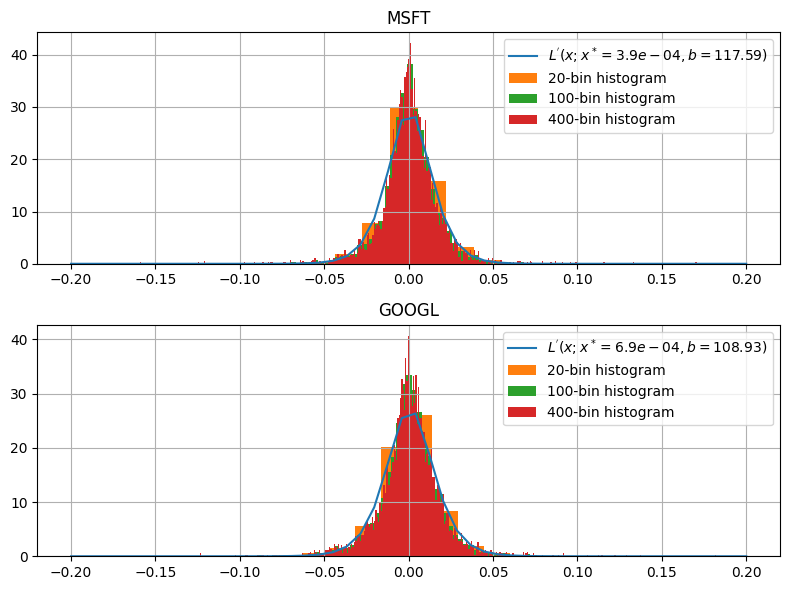

In [14]:
x_range = np.linspace(-0.2,0.2,50)
m = len(X.columns)
fig, axes = plt.subplots(2,1,figsize=(8,6))
for stock,ax in zip(X.columns,axes):
    ax.set_title(f"{stock}")
    x_star,b = logistic_fit(X[stock],dx=0.01)
    dL = logistic_derivate(x_range,x_star=x_star,b=b)
    ax.plot(x_range,dL,label=rf"$L^{{'}}(x; x^*={x_star:.1e},b={b:.2f})$")
    for k in (20,100,400):
        X[stock].hist(ax=ax,bins=k,density=True,label=f"{k}-bin histogram")
    ax.legend()
    ax.grid(True)
fig.tight_layout()
plt.savefig("../img/epdf.pdf")
plt.show()

# 5 Descriptive Statistics
- Compute the two return rates’ all-time means $\{\mu_1, \mu_2\}$, variances $\{\sigma_1^2, \sigma_2^2\}$
Sharpe ratios $\{\gamma_1, \gamma_2\}$, and covariance $\sigma_{12}$.
- Repeat last step using only the data on the 𝐾 most recent days (i.e. 𝑡 ≥
𝑁 − 𝐾 + 1) for 𝐾 = 30, 100, and 300.

In [15]:
def describe_stats(X,to_latex=False):
    mu = X.mean()
    sigma2 = X.var()
    gamma = X.mean()/X.std()
    table = pd.DataFrame({'mean':mu,'variance':sigma2,'sharp ration':gamma})
    cov = X.cov()
    display(table)
    display(Markdown("**Covariance Table**:"))
    display(cov)
    if to_latex:
        display(Markdown("**Table in latex**:"))
        print(table.to_latex())
        print(cov.to_latex())

In [16]:
display(Markdown("### Descriptive Statistics(all-time):"))
describe_stats(X,to_latex=True)

### Descriptive Statistics(all-time):

,mean,variance,sharp ration
MSFT,0.000566,0.000302,0.032540
GOOGL,0.000630,0.000359,0.033221


**Covariance Table**:

,MSFT,GOOGL
MSFT,0.000302,0.000195
GOOGL,0.000195,0.000359


**Table in latex**:

\begin{tabular}{lrrr}
\toprule
{} &      mean &  variance &  sharp ration \\
\midrule
MSFT  &  0.000566 &  0.000302 &      0.032540 \\
GOOGL &  0.000630 &  0.000359 &      0.033221 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrr}
\toprule
{} &      MSFT &     GOOGL \\
\midrule
MSFT  &  0.000302 &  0.000195 \\
GOOGL &  0.000195 &  0.000359 \\
\bottomrule
\end{tabular}



In [17]:
for k in (30,100,300):
    display(Markdown(rf"### Descriptive Statistics($k={k}$ most recent days):"))
    describe_stats(X.iloc[-k:],to_latex=True)

### Descriptive Statistics($k=30$ most recent days):

,mean,variance,sharp ration
MSFT,0.001474,0.00041,0.072799
GOOGL,-0.000754,0.00088,-0.025415


**Covariance Table**:

,MSFT,GOOGL
MSFT,0.000410,0.000409
GOOGL,0.000409,0.000880


**Table in latex**:

\begin{tabular}{lrrr}
\toprule
{} &      mean &  variance &  sharp ration \\
\midrule
MSFT  &  0.001474 &   0.00041 &      0.072799 \\
GOOGL & -0.000754 &   0.00088 &     -0.025415 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrr}
\toprule
{} &      MSFT &     GOOGL \\
\midrule
MSFT  &  0.000410 &  0.000409 \\
GOOGL &  0.000409 &  0.000880 \\
\bottomrule
\end{tabular}



### Descriptive Statistics($k=100$ most recent days):

,mean,variance,sharp ration
MSFT,0.000075,0.000554,0.003179
GOOGL,-0.001210,0.000704,-0.045574


**Covariance Table**:

,MSFT,GOOGL
MSFT,0.000554,0.000514
GOOGL,0.000514,0.000704


**Table in latex**:

\begin{tabular}{lrrr}
\toprule
{} &      mean &  variance &  sharp ration \\
\midrule
MSFT  &  0.000075 &  0.000554 &      0.003179 \\
GOOGL & -0.001210 &  0.000704 &     -0.045574 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrr}
\toprule
{} &      MSFT &     GOOGL \\
\midrule
MSFT  &  0.000554 &  0.000514 \\
GOOGL &  0.000514 &  0.000704 \\
\bottomrule
\end{tabular}



### Descriptive Statistics($k=300$ most recent days):

,mean,variance,sharp ration
MSFT,-0.000842,0.000474,-0.038648
GOOGL,-0.001575,0.000594,-0.064624


**Covariance Table**:

,MSFT,GOOGL
MSFT,0.000474,0.000438
GOOGL,0.000438,0.000594


**Table in latex**:

\begin{tabular}{lrrr}
\toprule
{} &      mean &  variance &  sharp ration \\
\midrule
MSFT  & -0.000842 &  0.000474 &     -0.038648 \\
GOOGL & -0.001575 &  0.000594 &     -0.064624 \\
\bottomrule
\end{tabular}

\begin{tabular}{lrr}
\toprule
{} &      MSFT &     GOOGL \\
\midrule
MSFT  &  0.000474 &  0.000438 \\
GOOGL &  0.000438 &  0.000594 \\
\bottomrule
\end{tabular}



##  6. Mean-Variance Analysis
We would like to perform a mean-variance analysis on $X_1(t)$ and $X_2(t)$ and
accordingly construct the minimum-risk portfolio $S_p(t) = pS_1(t)+(1-p)S_2(t)$  for some fraction of investment 𝑝 ∈ [0, 1].
- Determine 𝑝 according to the stocks’ all-time statistics.
- Plot the resultant portfolio’s $S_p(t)$ atop $S_1(t)$ and $S_2(t)$.

In [18]:
from scipy.linalg import null_space

def find_weight(X):
    Sigma = X.cov().to_numpy()
    N = len(Sigma)
    A = np.concatenate([2*Sigma,-np.ones([N,1])],axis=1)
    p = null_space(A)[:2]
    return p/p.sum()

In [19]:
p = find_weight(X)
p

array([[0.60467945],
       [0.39532055]])

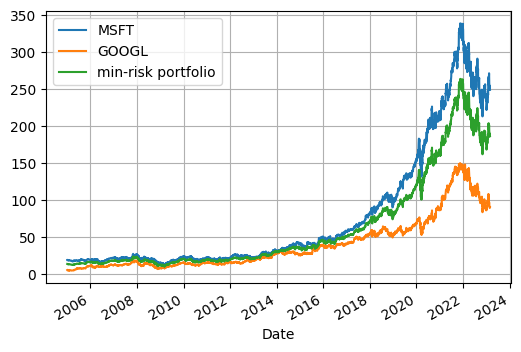

In [20]:
fig,ax = plt.subplots(figsize=(6,4))
Sp=S@p
S.plot(ax=ax)
ax.plot(Sp.index,Sp[0],label="min-risk portfolio")
ax.grid(True)
ax.legend()
plt.savefig("../img/min_risk.pdf")
plt.show()

## 6.1 A 𝑲-Day Analysis
As the relevance of old data should decay, it is more sensible to consider the
stocks’ performance on the 𝐾 most recent days only. In other words, we only
infer information from $\{X(t-\tau)|\tau\in(0,K-1)\}$ at every moment 𝑡 .

Hence, the fraction of investment, now denoted by 𝑝(𝑡, 𝐾), varies with time
and depends on 𝐾. Complete the following tasks for 𝐾 = 30, 100, and 300.
- Plot 𝑝(𝑡, 𝐾).
- Plot the resultant portfolio $S_p(t,K)$ atop $S_1(t)$ and $S_2(t)$.
- Plot $S_p(t,K)$’s 𝐾-day Sharpe ratio $\gamma_p(t,K)=\mu_p(t,K)/\sigma_p(t,K)$.
- An all-time analysis in some sense sets 𝐾 → ∞. Discuss the effect of 𝐾 on
the portfolio’s performance.

In [21]:
def k_day_(X,S,K=30):
    Sp_df = S.copy()
    N = len(Sp_df)
    Sp_df['p'] = np.zeros(N)
    Sp_df['portfolio'] = np.zeros(N)
    Sp_df['gamma_p'] = np.zeros(N)
    for t in range(K,N):
        p = find_weight(X.iloc[t-K:t])
        Sp_df.p.iloc[t] = p[0]
        Sp_df.portfolio.iloc[t] = S.iloc[t]@p
        Sp_K = Sp_df.portfolio.iloc[t-K:t]
        Sp_df.gamma_p.iloc[t] = Sp_K.mean()/Sp_K.std()
    return Sp_df

In [22]:
Ks = (30,100,300)
Sps = [k_day_(X,S,K=K) for K in Ks]

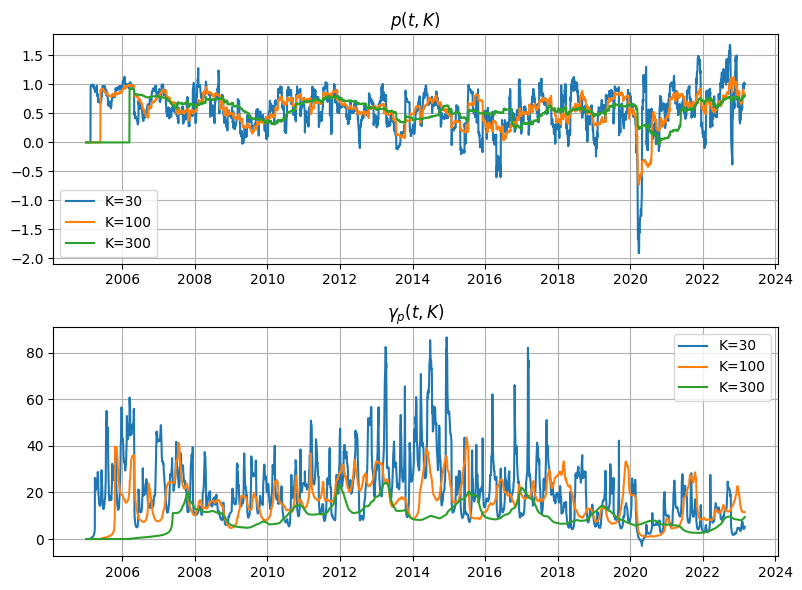

In [23]:
fig, axes = plt.subplots(2,1,figsize=(8,6))
for Sp,K in zip(Sps,Ks):
    axes[0].plot(Sp.p,label=f"K={K}")
    axes[1].plot(Sp.gamma_p,label=f"K={K}")
axes[0].set_title("$p(t,K)$")
axes[1].set_title("$\gamma_p(t,K)$")
for ax in axes:
    ax.grid(True)
    ax.legend()
fig.tight_layout()
plt.savefig("../img/k_day_analysis.pdf")
plt.show()

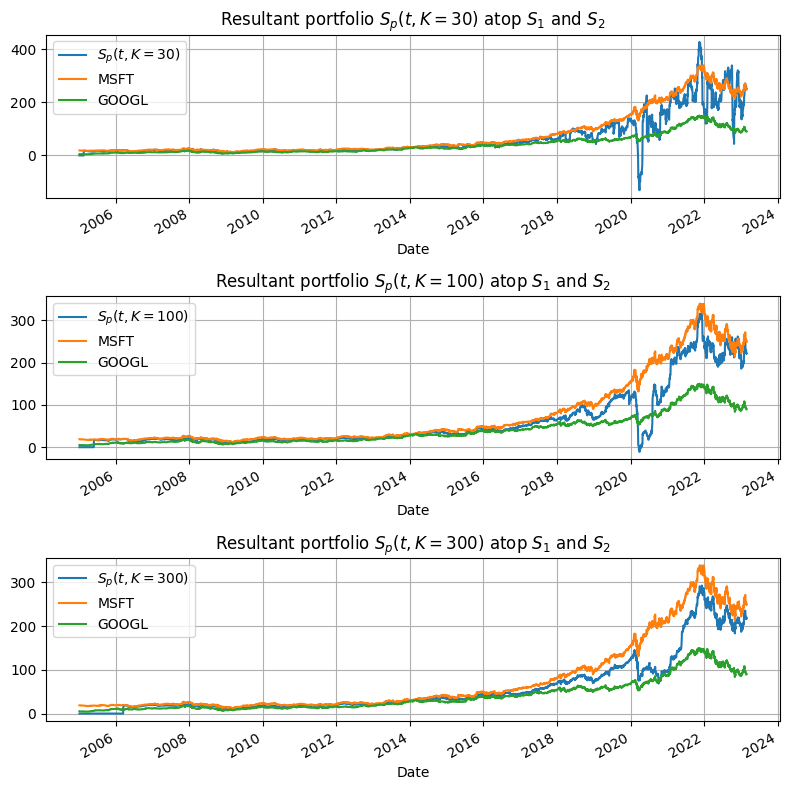

In [24]:
fig, axes = plt.subplots(len(Ks),1,figsize=(8,8))
for Sp,K,ax in zip(Sps,Ks,axes):
    ax.plot(Sp.portfolio,label=rf"$S_p(t,K={K})$")
    S.plot(ax=ax)
    ax.set_title(rf"Resultant portfolio $S_p(t,K={K})$ atop $S_1$ and $S_2$")
for ax in axes:
    ax.grid(True)
    ax.legend()
fig.tight_layout()
plt.savefig("../img/k_day_analysis_Sp.pdf")
plt.show()

## 7. Digitization of Time Series
Now focus on the first stock, so its subscript “1” is hereafter dropped and
implied. Digitize 𝑋(𝑡) as 𝑌 (𝑡) with three alphabets, viz. D for “down”, U for
“up”, and H for “hold”.
$$
Y(t)=
\begin{cases}
D, &X(t)<-\epsilon,\\
U, &X(t)>+\epsilon,\\
H, &otherwise.
\end{cases}
$$
Here let us use 𝜀 = 0.002, whereas you may of course choose other values in
real applications.
- Calculate the probability $P[Y(t)=y]$ for 𝑦 ∈ {D, U, H}.
- Calculate the conditional probability $P[Y(t+1)=y_1|Y(t)=y_2]$ for all
nine possible pairs of $(y_1,y_2)$ ∈ {D, U, H} × {D, U, H}.

In [25]:
def digitialize(X,epsilon=2e-3):
    return X.applymap(lambda x:'D' if x < -epsilon else 'U' if x > epsilon else 'H',na_action='ignore')

In [26]:
Y = digitialize(X)
Y

,MSFT,GOOGL
Date,,
2005-01-03,NaN,NaN
2005-01-04,U,D
2005-01-05,D,D
2005-01-06,H,D
2005-01-07,D,U
...,...,...
2023-02-22,D,H
2023-02-23,U,D
2023-02-24,D,D


In [27]:
Y1 = Y.iloc[:,0]

In [28]:
Count0 = Y1.value_counts()
Conf0 = Count0/Count0.sum()
Conf0

U    0.438827
D    0.408186
H    0.152988
Name: MSFT, dtype: float64

In [29]:
Conf1 = pd.DataFrame({'y1':Y1.shift(1),'y2':Y1}).value_counts()
for y1,y2 in product('DUH',repeat=2):
    Conf1.loc[(y1,y2)] /= Count0.loc[y2]
Conf1

y1  y2
D   U     0.432918
U   D     0.455764
    U     0.413965
D   D     0.398928
U   H     0.464950
H   U     0.152618
    D     0.145308
D   H     0.360515
H   H     0.174535
dtype: float64

In [30]:
print(pd.DataFrame({'p':Conf1}).to_latex())

\begin{tabular}{llr}
\toprule
  &   &         p \\
y1 & y2 &           \\
\midrule
D & U &  0.432918 \\
U & D &  0.455764 \\
  & U &  0.413965 \\
D & D &  0.398928 \\
U & H &  0.464950 \\
H & U &  0.152618 \\
  & D &  0.145308 \\
D & H &  0.360515 \\
H & H &  0.174535 \\
\bottomrule
\end{tabular}



## 8. Association Rules
We would like to find out a five-day pattern 𝐴 that associates well with an
immediate down (D). Formally, a rule 𝑅 can be written as
𝑅 ∶ 𝐴 = {𝑌 (𝑡 − 4), 𝑌 (𝑡 − 3), 𝑌 (𝑡 − 2), 𝑌 (𝑡 − 1), 𝑌 (𝑡)} → 𝑌 (𝑡 + 1) = D (6)
or just 𝑅 ∶ 𝐴 → D. Since the consequence of 𝑅 is always D, we may simplify
our notation by labelling 𝑅 with only the five alphabets of 𝐴; for example, the
rule 𝑅 = UUUUU predicts a down after five consecutive ups. There are 3Θ =
243 possible rules.
- Divide 𝑌 (𝑡) into the “past” and the “future” at 𝑡 = 𝑀 ≈ 3𝑁 /4. We hope to
get good association rules by examining the history on the previous 3000
days and then apply them on the coming 1000 days to make a profit.
- Calculate the confidence of all the 243 rules in the past, then report the 10
rules with the highest confidence. Denote them as $\{R_{conf}\}_p$. (Hereafter a
subscript “𝑝” represents inference from the past data, whereas a subscript
“𝑓” represents inference the future data.)

In [31]:
def top10(x):
    return x.sort_values(ascending=False).iloc[:10]

def common_rules(a,b):
    return set(a.index).intersection(b.index)

def Count(k:int,Y,start=1):
    return pd.DataFrame({f"y_{{t{'+' if (start-i) >= 0 else ''}{start-i}}}":Y.shift(k-i) for i in range(k+1)}).value_counts()

def Support(k:int,Y):
    return Count(k-1,Y,start=0)

def Conf(k:int,Y):
    SupportY_k = Support(k,Y)
    CountY_k = Count(k,Y)
    ConfY_k = CountY_k.copy()
    for idx in product('DUH',repeat=k+1):
        try:
            ConfY_k.loc[idx] /= SupportY_k.loc[idx[1:]]
        except KeyError:
            pass
    return ConfY_k

In [32]:
M = 3*len(Y1)//4
Y1_p = Y1.iloc[:M]
Y1_f = Y1.iloc[M:]
Conf_p = Conf(5,Y1_p).loc['D']
Conf_p

y_{t+0}  y_{t-1}  y_{t-2}  y_{t-3}  y_{t-4}
D        U        D        D        U          0.475410
                  U        D        U          0.466667
U        U        D        U        U          0.528302
D        U        D        D        D          0.562500
U        D        D        U        D          0.490909
                                                 ...   
D        H        H        H        U          0.333333
                  U        U        H          0.333333
                           H        D          0.166667
                  H        U        U          0.200000
                                    H          0.500000
Length: 214, dtype: float64

In [33]:
Support_p = Support(5,Y1_p)
Support_p

y_{t+0}  y_{t-1}  y_{t-2}  y_{t-3}  y_{t-4}
D        U        D        D        U          61
U        D        U        D        U          61
D        U        U        D        U          60
         D        U        D        D          59
U        D        D        D        U          56
                                               ..
H        H        U        H        H           1
         U        H        D        H           1
                           H        H           1
D        D        H        H        H           1
         H        D        H        H           1
Length: 240, dtype: int64

In [34]:
Count_p = Count(5,Y1_p).loc['D']
Count_p

y_{t+0}  y_{t-1}  y_{t-2}  y_{t-3}  y_{t-4}
D        U        D        D        U          29
                  U        D        U          28
U        U        D        U        U          28
D        U        D        D        D          27
U        D        D        U        D          27
                                               ..
D        H        H        H        U           1
                  U        U        H           1
                           H        D           1
                  H        U        U           1
                                    H           1
Length: 214, dtype: int64

In [35]:
(Support_p*Conf_p).dropna()

y_{t+0}  y_{t-1}  y_{t-2}  y_{t-3}  y_{t-4}
D        D        D        D        D          17.0
                                    H           4.0
                                    U          21.0
                           H        D           3.0
                                    U           5.0
                                               ... 
U        U        U        H        H           3.0
                                    U           8.0
                           U        D          18.0
                                    H           8.0
                                    U          19.0
Length: 214, dtype: float64

In [36]:
R_conf_p = top10(Conf_p)
R_conf_p

y_{t+0}  y_{t-1}  y_{t-2}  y_{t-3}  y_{t-4}
U        D        D        H        H          1.000000
                  H        H        H          1.000000
D        H        H        D        H          1.000000
H        U        H        D        H          1.000000
                           H        H          1.000000
D        D        H        H        H          1.000000
H        D        H        D        U          0.833333
U        D        H        U        H          0.800000
D        D        H        D        H          0.800000
U        H        D        D        U          0.785714
dtype: float64

In [37]:
print(pd.DataFrame({'probability':R_conf_p}).to_latex())

\begin{tabular}{lllllr}
\toprule
  &   &   &   &   &  probability \\
y\_\{t+0\} & y\_\{t-1\} & y\_\{t-2\} & y\_\{t-3\} & y\_\{t-4\} &              \\
\midrule
U & D & D & H & H &     1.000000 \\
  &   & H & H & H &     1.000000 \\
D & H & H & D & H &     1.000000 \\
H & U & H & D & H &     1.000000 \\
  &   &   & H & H &     1.000000 \\
D & D & H & H & H &     1.000000 \\
H & D & H & D & U &     0.833333 \\
U & D & H & U & H &     0.800000 \\
D & D & H & D & H &     0.800000 \\
U & H & D & D & U &     0.785714 \\
\bottomrule
\end{tabular}



## 9. Verification of Association Rules
We may verify a rule’s goodness by doing a betting experiment with the fu- ture data like this: as time passes, we bet on an immediate down every day. If a down indeed comes out, we earn \$𝑢, and we ascribe the profit to the just appeared five-day pattern 𝐴 and its rule 𝑅 ∶ 𝐴 → D; otherwise, we lose \$𝑣, and we similarly ascribe the loss to the just appeared pattern.
Consider 𝑢 = 1 and 𝑣 = 0 for simplicity. In this regard, a rule’s profit is merely the number of times that it works.
- Record the profits due to all the 243 rules, then report the 10 most profita- ble rules. Denote them as $\{R_{expt}\}_f$.

In [38]:
Profit_f = Count(5,Y1_f).loc['D']
R_expt_f = top10(Profit_f)
R_expt_f

y_{t+0}  y_{t-1}  y_{t-2}  y_{t-3}  y_{t-4}
U        U        D        D        U          14
         D        D        U        U          12
                  U        U        U          12
         U        U        U        D          12
D        U        D        U        U          11
U        U        U        U        U          10
                  D        U        U          10
D        U        U        D        U           9
U        D        U        D        D           9
         U        D        U        D           9
dtype: int64

In [39]:
print(pd.DataFrame({'probability':R_expt_f}).to_latex())

\begin{tabular}{lllllr}
\toprule
  &   &   &   &   &  probability \\
y\_\{t+0\} & y\_\{t-1\} & y\_\{t-2\} & y\_\{t-3\} & y\_\{t-4\} &              \\
\midrule
U & U & D & D & U &           14 \\
  & D & D & U & U &           12 \\
  &   & U & U & U &           12 \\
  & U & U & U & D &           12 \\
D & U & D & U & U &           11 \\
U & U & U & U & U &           10 \\
  &   & D & U & U &           10 \\
D & U & U & D & U &            9 \\
U & D & U & D & D &            9 \\
  & U & D & U & D &            9 \\
\bottomrule
\end{tabular}



- How many rules does $\{R_{conf}\}_p$ share with $\{R_{expt}\}_f$ ?

In [40]:
common_rules(R_conf_p,R_expt_f)

set()

In [41]:
Conf_f = Conf(5,Y1_f).loc['D']
Conf_f_top10 = top10(Conf_f)
Conf_f_top10

y_{t+0}  y_{t-1}  y_{t-2}  y_{t-3}  y_{t-4}
D        H        H        U        U          1.0
H        D        H        U        U          1.0
                  U        D        U          1.0
D        H        U        H        D          1.0
                  D        H        U          1.0
H        D        H        D        U          1.0
U        U        D        H        H          1.0
         H        H        U        U          1.0
H        H        D        D        U          1.0
U        H        H        D        D          1.0
dtype: float64

In [42]:
common_rules(R_conf_p,Conf_f_top10)

{('H', 'D', 'H', 'D', 'U')}

- Compute the correlation between a rule’s confidence in the past and its
profit in the future.

In [43]:
conf_profit = pd.concat([Conf_p,Profit_f],axis=1).fillna(0)
conf_profit.columns = ['Confidence(Past)','Profit(Future)']
conf_profit

Confidence(Past)  Profit(Future)
y_{t+0} y_{t-1} y_{t-2} y_{t-3} y_{t-4}                                  
D       U       D       D       U                0.475410             9.0
                U       D       U                0.466667             9.0
U       U       D       U       U                0.528302            10.0
D       U       D       D       D                0.562500             7.0
U       D       D       U       D                0.490909             9.0
...                                                   ...             ...
H       H       D       H       U                0.000000             1.0
D       D       D       H       H                0.000000             1.0
H       U       U       H       D                0.000000             1.0
D       H       D       U       H                0.000000             1.0
U       H       H       U       H                0.000000             1.0

[222 rows x 2 columns]

In [44]:
conf_profit.corr()

,Confidence(Past),Profit(Future)
Confidence(Past),1.000000,0.003803
Profit(Future),0.003803,1.000000


In [45]:
conf_conf = pd.concat([Conf_p,Conf_f],axis=1,join='outer').fillna(0)
conf_conf.columns = ['Confidence(Past)','Confidence(Future)']
conf_conf

Confidence(Past)  Confidence(Future)
y_{t+0} y_{t-1} y_{t-2} y_{t-3} y_{t-4}                                      
D       U       D       D       U                0.475410            0.391304
                U       D       U                0.466667            0.450000
U       U       D       U       U                0.528302            0.434783
D       U       D       D       D                0.562500            0.583333
U       D       D       U       D                0.490909            0.321429
...                                                   ...                 ...
H       H       D       H       U                0.000000            1.000000
D       D       D       H       H                0.000000            1.000000
H       U       U       H       D                0.000000            0.500000
D       H       D       U       H                0.000000            1.000000
U       H       H       U       H                0.000000            0.500000

[222 rows x 2 columns]

In [46]:
conf_conf.corr()

,Confidence(Past),Confidence(Future)
Confidence(Past),1.000000,-0.131539
Confidence(Future),-0.131539,1.000000


In [47]:
Support_f = Support(5,Y1_f)
Support_f

y_{t+0}  y_{t-1}  y_{t-2}  y_{t-3}  y_{t-4}
U        U        D        D        U          30
         D        D        U        D          28
                                    U          24
D        U        D        D        U          23
U        U        U        U        D          23
                                               ..
D        H        D        D        H           1
U        H        D        H        D           1
                  H        H        H           1
D        U        U        H        H           1
         H        H        D        H           1
Length: 205, dtype: int64

In [48]:
supp_supp = pd.concat([Support_p,Support_f],axis=1,join='outer').fillna(0)
supp_supp.corr()

,0,1
0,1.000000,0.876739
1,0.876739,1.000000


### 10.1 Geometric mean and Arithmetic Mean
Let us first boldly assume that all rules obey $s_p= s_f$ and $c_p= c_f$ , yielding $\pi\sim s_pc_p$. Since the ranking of 𝜋 does not change when we take a square root on the right-hand side, we may predict a rule’s goodness with the geometric mean between its support and confidence. Out of curiosity, we may also guess whether their arithmetic mean is useful.
- Report the 10 rules with the highest geometric mean between support and confidence in the past, i.e. $\sqrt{s_p c_p}$. Denote them as $\{R_{geo}\}_p$.
- Report the 10 rules with the highest arithmetic mean between support and confidence in the past, i.e. $\frac{s_p+c_p}2$. Denote them as $\{R_{ari}\}_p$.
- How many rules do $\{R_{geo}\}_p$ and $\{R_{ari}\}_p$ share with $\{R_{expt}\}_f$ ? Do the two means assess a rule better than confidence?

In [49]:
geo_p = ((Support_p*Conf_p)**.5).dropna()
R_geo_p = top10(geo_p)
R_geo_p

y_{t+0}  y_{t-1}  y_{t-2}  y_{t-3}  y_{t-4}
D        U        D        D        U          5.385165
                  U        D        U          5.291503
U        U        D        U        U          5.291503
D        U        D        D        D          5.196152
U        D        D        U        D          5.196152
                           D        U          5.099020
                  U        D        U          5.099020
D        D        U        D        D          5.000000
                           U        D          4.898979
U        U        D        D        D          4.690416
dtype: float64

In [50]:
print(pd.DataFrame({'Geometric mean':R_geo_p}).to_latex())

\begin{tabular}{lllllr}
\toprule
  &   &   &   &   &  Geometric mean \\
y\_\{t+0\} & y\_\{t-1\} & y\_\{t-2\} & y\_\{t-3\} & y\_\{t-4\} &                 \\
\midrule
D & U & D & D & U &        5.385165 \\
  &   & U & D & U &        5.291503 \\
U & U & D & U & U &        5.291503 \\
D & U & D & D & D &        5.196152 \\
U & D & D & U & D &        5.196152 \\
  &   &   & D & U &        5.099020 \\
  &   & U & D & U &        5.099020 \\
D & D & U & D & D &        5.000000 \\
  &   &   & U & D &        4.898979 \\
U & U & D & D & D &        4.690416 \\
\bottomrule
\end{tabular}



In [51]:
common_rules(R_geo_p,R_expt_f)

{('D', 'U', 'U', 'D', 'U'), ('U', 'U', 'D', 'U', 'U')}

In [52]:
ari_p = ((Support_p+Conf_p)/2).dropna()
R_ari_p = top10(ari_p)
R_ari_p

y_{t+0}  y_{t-1}  y_{t-2}  y_{t-3}  y_{t-4}
D        U        D        D        U          30.737705
U        D        U        D        U          30.713115
D        U        U        D        U          30.233333
         D        U        D        D          29.711864
U        D        D        D        U          28.232143
                           U        D          27.745455
         U        D        U        U          26.764151
                                    D          26.698113
D        U        D        U        D          25.170000
U        U        D        D        D          24.724490
dtype: float64

In [53]:
print(pd.DataFrame({'mean':R_ari_p}).to_latex())

\begin{tabular}{lllllr}
\toprule
  &   &   &   &   &       mean \\
y\_\{t+0\} & y\_\{t-1\} & y\_\{t-2\} & y\_\{t-3\} & y\_\{t-4\} &            \\
\midrule
D & U & D & D & U &  30.737705 \\
U & D & U & D & U &  30.713115 \\
D & U & U & D & U &  30.233333 \\
  & D & U & D & D &  29.711864 \\
U & D & D & D & U &  28.232143 \\
  &   &   & U & D &  27.745455 \\
  & U & D & U & U &  26.764151 \\
  &   &   &   & D &  26.698113 \\
D & U & D & U & D &  25.170000 \\
U & U & D & D & D &  24.724490 \\
\bottomrule
\end{tabular}



In [54]:
set(R_ari_p.index).intersection(R_expt_f.index)

{('D', 'U', 'U', 'D', 'U'),
 ('U', 'U', 'D', 'U', 'D'),
 ('U', 'U', 'D', 'U', 'U')}

### 10.2 A Generalized Mean
Now we will account for the discrepancy between the past and the future, so $s_p\neq s_f$ and $c_p\neq c_f$. We are pessimistic, so we expect that a rule’s confidence depreciates over time, but we are also optimistic, so we expect that a more confident rule in the past remains more confident in the future.
The two assumptions combine to suggest $c_f=c_p^m$ for some 𝑚 > 1. With the scale of 𝜋 maintained, we may formulate 𝜋 with a generalized mean
$$
\pi=(s_pc_p^m)^{\frac1{1+m}}=s_p^\lambda c_p^{1-\lambda}
$$
for some tuning parameter 𝜆 ≡ 1/(1 + 𝑚) ∈ [0, 1]. As 𝜆 rises, the emphasis of $s_p^\lambda c_p^{1-\lambda}$ smoothly slides from support to confidence. When 𝜆 strikes 1/3,$\pi=\sqrt[3]{s_pc_p^2}=\sqrt[3]{r_p}$, where $r_p$ is the rule’s rule power factor (RPF).

- Report the 10 rules with the highest RPF in the past. Denote them as $\{R_{RPF}\}_p$ .
- How many rules does $\{R_{RPF}\}_p$ share with $\{R_{expt}\}_f$ ? Hence, does RPF assess a rule better than confidence?
- Do you think there will be an optimal value for 𝜆 that best predict a rule’s goodness? If yes, what may it be? If no, why not?

In [55]:
def gmean(support,conf,λ=1/3):
    return (support**λ*conf**(1-λ)).dropna()

In [56]:
RPF_p = gmean(Support_p,Conf_p,λ=1/3)
R_RPF_p = top10(RPF_p)
R_RPF_p

y_{t+0}  y_{t-1}  y_{t-2}  y_{t-3}  y_{t-4}
D        U        D        D        D          2.476445
U        U        D        U        U          2.454785
D        U        D        D        U          2.397850
U        D        D        U        D          2.366582
D        U        U        D        U          2.355347
U        D        D        U        U          2.335360
                           D        U          2.293962
D        D        U        U        D          2.289428
U        D        U        D        U          2.229490
D        D        U        D        D          2.196221
dtype: float64

In [57]:
print(pd.DataFrame({'RPF':R_RPF_p}).to_latex())

\begin{tabular}{lllllr}
\toprule
  &   &   &   &   &       RPF \\
y\_\{t+0\} & y\_\{t-1\} & y\_\{t-2\} & y\_\{t-3\} & y\_\{t-4\} &           \\
\midrule
D & U & D & D & D &  2.476445 \\
U & U & D & U & U &  2.454785 \\
D & U & D & D & U &  2.397850 \\
U & D & D & U & D &  2.366582 \\
D & U & U & D & U &  2.355347 \\
U & D & D & U & U &  2.335360 \\
  &   &   & D & U &  2.293962 \\
D & D & U & U & D &  2.289428 \\
U & D & U & D & U &  2.229490 \\
D & D & U & D & D &  2.196221 \\
\bottomrule
\end{tabular}



In [58]:
common_rules(R_RPF_p,R_expt_f)

{('D', 'U', 'U', 'D', 'U'),
 ('U', 'D', 'D', 'U', 'U'),
 ('U', 'U', 'D', 'U', 'U')}

In [59]:
# find the best parameter λ
λs = np.linspace(0,1,101)
RPFs = [(λ,common_rules(top10(gmean(Support_p,Conf_p,λ=λ)),R_expt_f)) for λ in λs]
best_λ,best_R_shared = max(RPFs,key=lambda x:len(x[1]))
best_λ,best_R_shared

(0.25,
 {('D', 'U', 'U', 'D', 'U'),
  ('U', 'D', 'D', 'U', 'U'),
  ('U', 'U', 'D', 'U', 'U'),
  ('U', 'U', 'U', 'U', 'U')})